In [14]:
import torch
import random
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE

random.seed(42)

In [15]:
# Construct the list of names
words = list()
with open("names.txt", "r") as infile:
    for line in infile:
        words.append(line.strip())
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [16]:
len(words)

32033

In [17]:
# Mapping of characters to/from integers
special = "."
chars = sorted(list(set("".join(words))))
STOI = {s: i + 1 for i, s in enumerate(chars)}
STOI[special] = 0
ITOS = {i: s for s, i in STOI.items()}

In [18]:
# Construct the dataset


def build_dataset(words, *, special: str = ".") -> tuple[torch.tensor]:
    block_size = 3  # context length: amount of information to use to predict the next character
    (X, Y) = (list(), list())

    for word in words:
        context = [0] * block_size
        for char in word + special:
            ix = STOI[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"Constructed dataset: X: {X.shape}, Y: {Y.shape}")
    return X, Y


# Train, Development, Test split
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

Constructed dataset: X: torch.Size([182625, 3]), Y: torch.Size([182625])
Constructed dataset: X: torch.Size([22655, 3]), Y: torch.Size([22655])
Constructed dataset: X: torch.Size([22866, 3]), Y: torch.Size([22866])


11897
-0.23123124241828918


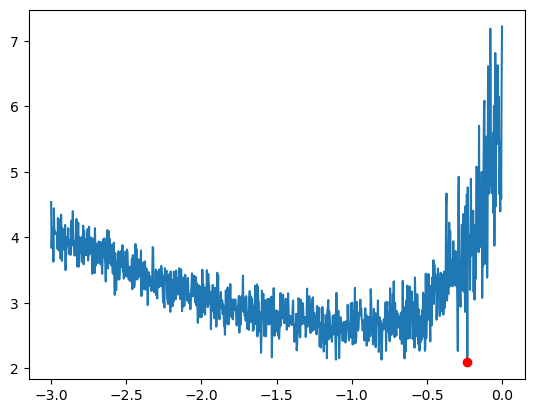

In [19]:
# Find the optimal learning rate by stepping through rates in exponential space

# Compress the set of characters into a 2D lookup table / embedding
n_embedding = 10
block_size = 3
n_hidden = 200
vocab_size = len(STOI)
gen = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embedding), generator=gen)
W1 = torch.randn((block_size * n_embedding, n_hidden), generator=gen)
b1 = torch.randn(n_hidden, generator=gen)
W2 = torch.randn((n_hidden, vocab_size), generator=gen) * 0.1
b2 = torch.randn(vocab_size, generator=gen) * 0.0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

n_steps = 1000
lre = torch.linspace(-3, 0, n_steps)
lrs = 10**lre

lri = []
lossi = []

for epoch in range(n_steps):

    # Get indices of minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    embedding = C[Xtr[ix]]
    h = torch.tanh(embedding.view(-1, block_size * n_embedding) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    learning_rate = lrs[epoch]
    for p in parameters:
        p.data += -learning_rate * p.grad

    lri.append(lre[epoch])
    lossi.append(loss.item())

# Find the index of minimal loss and map to stored learning rate
x = np.array(lossi)
index = np.where(x == x.min())[0].item()
optimal_rate = lre[index].item()

plt.plot(lri, lossi)
plt.plot(optimal_rate, lossi[index], marker="o", color="r")
print(optimal_rate)

Training model with 12097 parameters
Epoch 0 loss: 3.8132
Epoch 10000 loss: 2.5094
Epoch 20000 loss: 2.1412
Epoch 30000 loss: 2.2734
Epoch 40000 loss: 2.0915
Epoch 50000 loss: 2.1746
Epoch 60000 loss: 2.1853
Epoch 70000 loss: 2.0989
Epoch 80000 loss: 1.7036
Epoch 90000 loss: 2.0523
Epoch 100000 loss: 2.1845
Epoch 110000 loss: 2.0589
Epoch 120000 loss: 2.3008
Epoch 130000 loss: 2.4121
Epoch 140000 loss: 2.1039
Epoch 150000 loss: 2.2378
Epoch 160000 loss: 2.0331
Epoch 170000 loss: 1.9631
Epoch 180000 loss: 2.5399
Epoch 190000 loss: 2.0100
Epoch 200000 loss: 1.9161
Epoch 210000 loss: 2.1265
Epoch 220000 loss: 1.8842
Epoch 230000 loss: 2.2109
Epoch 240000 loss: 1.9855


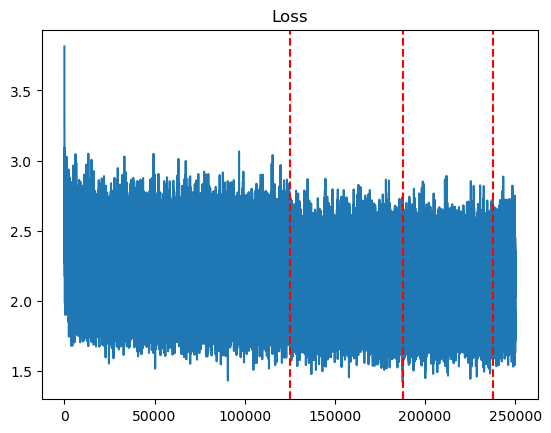

In [20]:
epoch_i = list()
loss_i = list()

n_epochs = 250_000
batch_size = 48
n_embedding = 10
block_size = 3
n_hidden = 200
vocab_size = len(STOI)

# Initialization tuning - https://pytorch.org/docs/stable/nn.init.html
tanh_gain = 5 / 3
fan_mode = block_size * n_embedding
kaiming_std = tanh_gain / fan_mode**0.5

gen = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embedding), generator=gen)
W1 = torch.randn((block_size * n_embedding, n_hidden), generator=gen) * kaiming_std
# b1 = torch.randn(n_hidden, generator=gen) * 0.01  # no use after introducing batchnorm
W2 = torch.randn((n_hidden, vocab_size), generator=gen) * 0.1
b2 = torch.randn(vocab_size, generator=gen) * 0.0

# batch-norm
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_momentum = 0.001

# Track batch-norm statistics for use in downstream model evaluation
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))


parameters = [
    C,
    W1,
    # b1,
    W2,
    b2,
    bn_gain,
    bn_bias,
]
n_params = sum(p.nelement() for p in parameters)
print(f"Training model with {n_params} parameters")

for p in parameters:
    p.requires_grad = True

for epoch in range(n_epochs):

    # Get indices of minibatch from the training data
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    Xbatch, Ybatch = Xtr[ix], Ytr[ix]

    # Forward pass using the training targets
    embedding = C[Xbatch]
    emb = embedding.view(-1, block_size * n_embedding)
    h_preactivation = emb @ W1  # + b1 the use of bias is spurious since we subtract bnmean later
    h_mean = h_preactivation.mean(0, keepdim=True)
    h_std = h_preactivation.std(0, keepdim=True)

    # Track batch-norm stats
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + bn_momentum * h_mean
        bnstd_running = 0.999 * bnstd_running + bn_momentum * h_std

    # Apply batch-norm
    h_preactivation = bn_gain * ((h_preactivation - h_mean) / h_std) + bn_bias

    h = torch.tanh(h_preactivation)  # batch_size, n_hidden
    logits = h @ W2 + b2  # batch_size, len(stoi)
    loss = F.cross_entropy(logits, Ybatch)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update and decay the learning rate if required
    current_rate = 0.0
    if epoch < 0.5 * n_epochs:
        current_rate = optimal_rate
    elif epoch > 0.5 * n_epochs and epoch < 0.75 * n_epochs:
        current_rate = optimal_rate / 10
    elif epoch > 0.75 * n_epochs and epoch < 0.95 * n_epochs:
        current_rate = optimal_rate / 100
    else:
        current_rate = optimal_rate / 1000

    for p in parameters:
        p.data += current_rate * p.grad

    epoch_i.append(epoch)
    loss_i.append(loss.item())

    if epoch % 10_000 == 0:
        print(f"Epoch {epoch} loss: {loss.item():.4f}")

plt.plot(epoch_i, loss_i)
decay_points = [0.5 * n_epochs, 0.75 * n_epochs, 0.95 * n_epochs]
for decay_point in decay_points:
    plt.axvline(int(decay_point), linestyle="--", color="r")
plt.title("Loss")
plt.show()

In [21]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xtest, Ytest),
    }[split]
    embedding = C[x]
    emb = embedding.view(-1, block_size * n_embedding)
    h_preactivation = emb @ W1 + b1

    # Apply batch-norm
    h_preactivation = bn_gain * ((h_preactivation - bnmean_running) / bnstd_running) + bn_bias

    h = torch.tanh(h_preactivation)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.4f}")


split_loss("train")
split_loss("val")

train loss: 2.1666
val loss: 2.2039


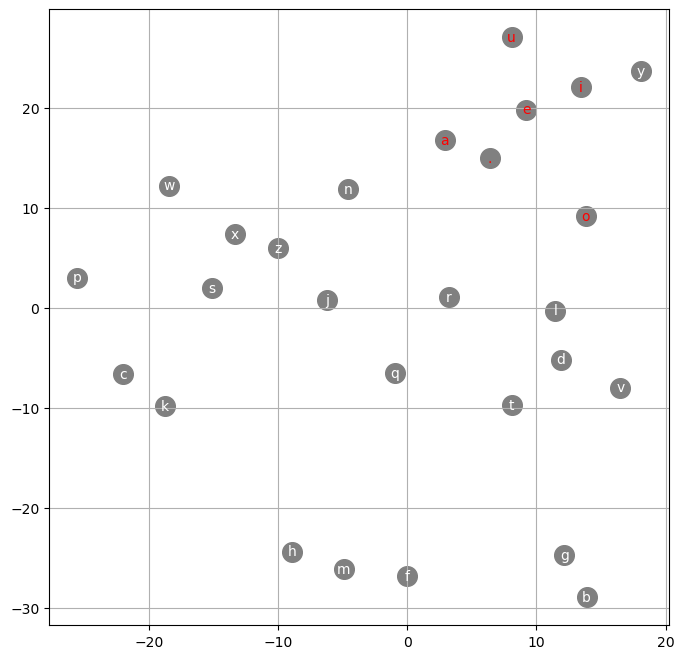

In [22]:
# Visualize the N-Dim NN character embedding
tsne = TSNE(n_jobs=4, perplexity=5, random_state=2147483647)
tsne_emb = tsne.fit_transform(C.detach().numpy())

plt.figure(figsize=(8, 8))
plt.scatter(tsne_emb[:, 0].data, tsne_emb[:, 1].data, s=200, color="gray")
for i in range(tsne_emb.shape[0]):
    char = ITOS[i]
    if char in ["a", "e", "i", "o", "u", "."]:
        color = "red"
    else:
        color = "white"
    plt.text(tsne_emb[i, 0].item(), tsne_emb[i, 1].item(), char, ha="center", va="center", color=color)
plt.grid("minor")

In [26]:
# Sample from the model and generate some basic names

gen = torch.Generator().manual_seed(57)

n_samples = 20
for _ in range(n_samples):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=gen).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(ITOS[i] for i in out))

abdder.
wilsbaddynnzader.
wynnaibbygustzppatchemsichbigakyliczapsudhailanghutghutgur.
whit.
kasximryliqwowdoddynnevynkabiganclaurg.
bryssagdalifbhz.
willabshdlivangthferway.
kanifferenjbaxryellktelijahzi.
kingtcfbudenextan.
kazrifferringtriffallawriggyf.
wilsteviqgav.
bryntobecklyntobenleights.
whingftumyzyahzubbaddbercewgorbigabbydikolkeslynticanpelbryntzibidenghovnggbbbdgunghul.
unerlytsmyclukilyfshbakstycyncalaniffalcewrgsn.
lcuwtl.
whligaklnngrapquzzdow.
dylenaxhaydyklucilexxnixisriqgyu.
wildng.
whitnllewryssaggurggrdestan.
hzmozzabellanghudzynzilygabbretchendvingeliancladhlyntobethrawnzynghukissancaspeqlaurghutgyvyerghlynnliyzbeddha.
